# Gradient Boosting

### http://blog.csdn.net/han_xiaoyang/article/details/52663170

- Boosting算法对同时控制偏差（bias）和方差都有非常好的效果，而且更加高效。
- Boosting可以将一系列弱学习因子（weak learners）相结合来提升总体模型的预测准确度。在任意时间t，根据t-1时刻得到的结果我们给当前结果赋予一个权重。之前正确预测的结果获得较小权重，错误分类的结果得到较大权重。


### GBM的参数可以被归为三类：

- Tree parameter：调节模型中每个决定树的性质
- Boosting参数：调节模型中boosting的操作
- 其他模型参数：调节模型总体的各项运作

### 參數定義參考 GBM parameter.xlsx

In [1]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('train_modified.csv')
target = 'Disbursed'
IDcol = 'ID'

E:\Programming\Python\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\Programming\Python\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## 使用默認設置先建一個model，default就已經不錯了


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.862264
CV Score : Mean - 0.8318589 | Std - 0.008756969 | Min - 0.820805 | Max - 0.8438558


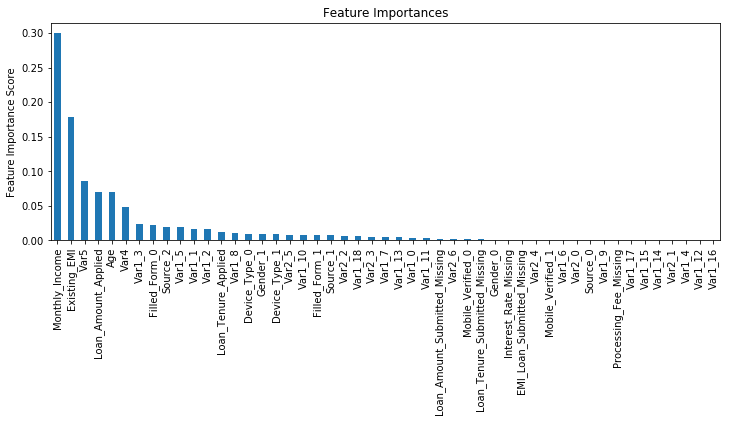

In [3]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

##  Parameter Tuning

- learning rate没有什么特别的调节方法，因为只要我们训练的树足够多learning rate总是小值来得好
- 需要注意一下调参顺序，对结果影响最大的参数应该优先调节，就像max_depth和num_samples_split

先固定 learning rate
- 1.调节max_depth和 num_samples_split
- 2.调节min_samples_leaf
- 3.调节max_features

其他參數固定後

降低learning_rate  同時提高n_estimators

In [8]:
feat_imp = pd.Series(gbm0.feature_importances_, predictors)
feat_imp

Existing_EMI                     0.178044
Loan_Amount_Applied              0.070204
Loan_Tenure_Applied              0.012332
Monthly_Income                   0.299690
Var4                             0.048807
Var5                             0.086156
Age                              0.070185
EMI_Loan_Submitted_Missing       0.000932
Interest_Rate_Missing            0.000970
Loan_Amount_Submitted_Missing    0.002188
Loan_Tenure_Submitted_Missing    0.001638
Processing_Fee_Missing           0.000000
Device_Type_0                    0.009426
Device_Type_1                    0.008886
Filled_Form_0                    0.022618
Filled_Form_1                    0.007541
Gender_0                         0.001222
Gender_1                         0.009285
Var1_0                           0.003952
Var1_1                           0.016355
Var1_2                           0.015991
Var1_3                           0.023839
Var1_4                           0.000000
Var1_5                           0

## 模行調校 ....

- 固定learning_rate
- gridsearch 找n_estimator
- 调节max_depth和 num_samples_split
- 调节min_samples_leaf
- 调节max_features
- subsamples
- 調低learning_rate 同時增加 n_estimator